<h1>Imports y Configuraciones Iniciales</h1>

In [98]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from PIL import Image
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

In [99]:
TIPO_IMAGENES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

# configurar los directorios de las imágenes

#TRAIN_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/train')
#TEST_DIR = Path('./ucse-ia-2024-tp-2-clasificacion-de-imagenes/test')

TRAIN_DIR = r"C:\Users\54934\Downloads\train"
TEST_DIR = r"C:\Users\54934\Downloads\test"

SIZE = 128

In [100]:
images_reader = ImageDataGenerator(
    rescale=1/255,  # Normaliza los píxeles a valores entre 0 y 1
    rotation_range=20,  # Rotar imágenes aleatoriamente entre 0 y 20 grados
    width_shift_range=0.2,  # Desplazar horizontalmente hasta el 20% del ancho
    height_shift_range=0.2,  # Desplazar verticalmente hasta el 20% de la altura
    shear_range=0.2,  # Cortar (shear) imágenes aleatoriamente
    zoom_range=0.2,  # Ampliar imágenes aleatoriamente
    horizontal_flip=True,  # Voltear imágenes horizontalmente
    fill_mode='nearest',  # Estrategia para rellenar nuevos píxeles
    brightness_range=(0.5, 1.5),  # Cambiar brillo aleatoriamente
    validation_split=0.2  # Porcentaje para la validación (20%)
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=TIPO_IMAGENES, # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE), # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    batch_size=32, # Tamaño del lote
)

test_dir = Path(TEST_DIR)
file_info = [{'filename': f.name, 'filepath': str(test_dir / f.name)} for f in test_dir.iterdir() if f.is_file()]
test_df = pd.DataFrame(file_info)
test = images_reader.flow_from_dataframe(dataframe=test_df, x_col='filepath', y_col=None, target_size=(SIZE, SIZE), batch_size=32, class_mode=None, shuffle=False)

Found 3000 validated image filenames.


In [101]:
# Generador para entrenamiento (80%)
train = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    **READ_PARAMS
)

# Generador para validación (20%)
validation = images_reader.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    **READ_PARAMS
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [102]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(TIPO_IMAGENES[np.argmax(labels[i])])
        plt.axis("off")

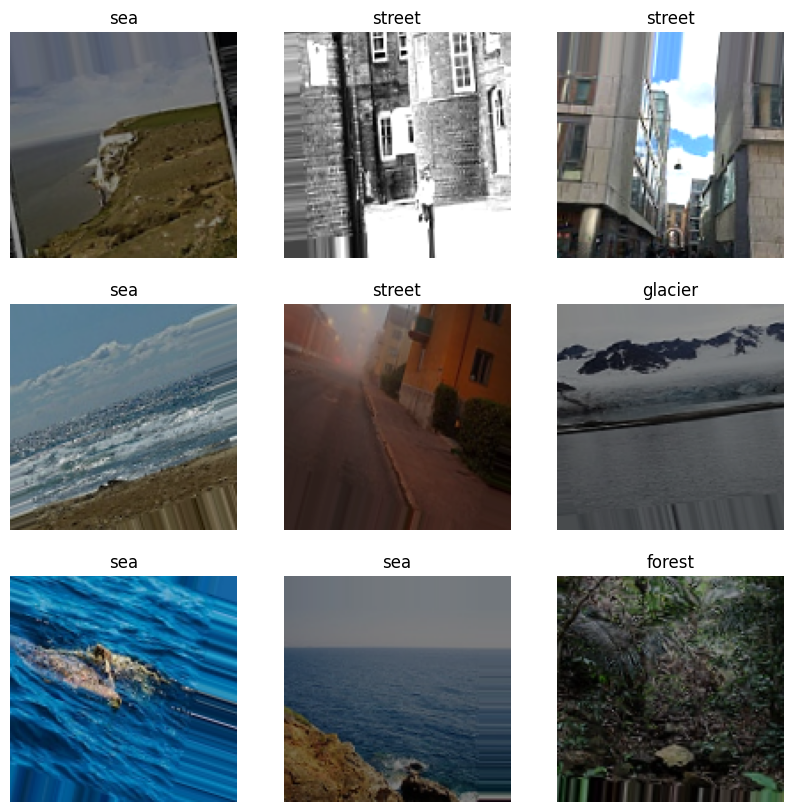

In [103]:
sample_images(train)

<h1>Análisis Exploratorio del conjunto de datos</h1>

<h2> Estructura y Formato </h2>

In [104]:
# Funcion que devuelve la estructura de 10 imágenes random de cada subcarpeta del dataset de train
import random
def image_structure_info(dataset_dir, num_examples=10):
    for root, _, files in os.walk(dataset_dir):
        if files:
            print(f"Subcarpeta: {os.path.relpath(root, dataset_dir)}")
            random_files = random.sample(files, min(num_examples, len(files)))
            for file in random_files:
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                image_format = image.format
                image_size = image.size
                print(f"- Nombre: {file}, Formato: {image_format}, Tamaño: {image_size}")

image_structure_info(TRAIN_DIR, num_examples=10)

Subcarpeta: buildings
- Nombre: 7563.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 18993.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 15304.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 14885.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 17539.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 17198.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 904.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 9767.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 508.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 11054.jpg, Formato: JPEG, Tamaño: (150, 150)
Subcarpeta: forest
- Nombre: 12308.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 8750.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 5825.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 11679.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 7802.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 18691.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 2091.jpg, Formato: JPEG, Tamaño: (150, 150)
- Nombre: 13280.jpg, Formato: JPEG

<h2> Volumetría </h2>

In [105]:
# Funcion que devuelve la volumetria en los datos en el dataset de train
def dataset_volumetrics(dataset):
    num_samples = 0
    class_counts = {}
    
    for root, _, files in os.walk(dataset.directory):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            num_samples += num_images
            class_counts[class_name] = num_images
    
    num_classes = len(class_counts)
    
    return num_samples, num_classes, class_counts

num_samples, num_classes, class_counts = dataset_volumetrics(train)
print(f"Número total de muestras en el dataset: {num_samples}")
print(f"Número de clases en el dataset: {num_classes}")
print("Cantidad de muestras por clase:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

Número total de muestras en el dataset: 14034
Número de clases en el dataset: 6
Cantidad de muestras por clase:
- buildings: 2191
- forest: 2271
- glacier: 2404
- mountain: 2512
- sea: 2274
- street: 2382


<h2> Distribución de la Variable a predecir </h2>

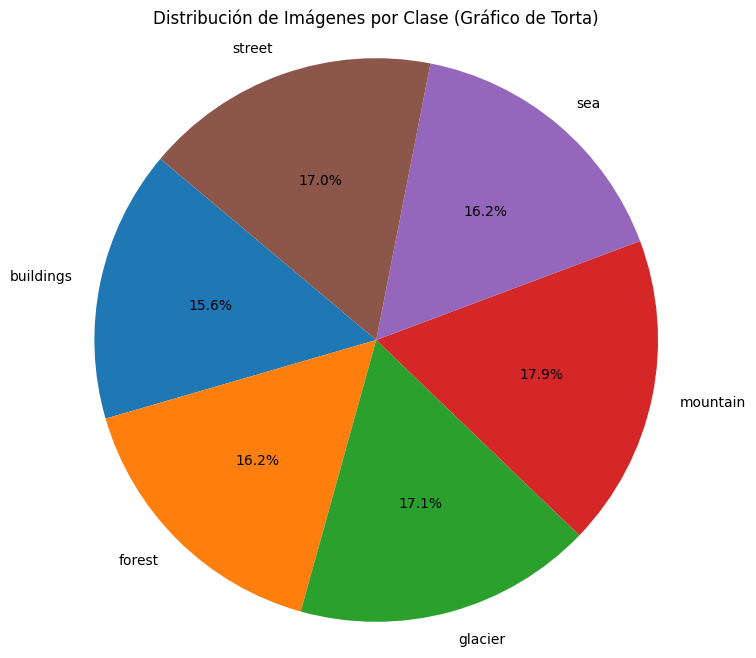

Información adicional:
Número total de clases: 6
Número total de imágenes: 14034
Clases con mayor cantidad de imágenes:
- mountain: 2512 imágenes
- glacier: 2404 imágenes
- street: 2382 imágenes
- sea: 2274 imágenes
- forest: 2271 imágenes


In [106]:
def plot_image_distribution_pie(dataset_dir):
    class_counts = {}
    
    for root, _, files in os.walk(dataset_dir):
        if files:
            class_name = os.path.basename(root)
            num_images = len(files)
            class_counts[class_name] = num_images
    
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Distribución de Imágenes por Clase (Gráfico de Torta)')
    plt.show()
    
    print("Información adicional:")
    print(f"Número total de clases: {len(class_counts)}")
    print(f"Número total de imágenes: {sum(class_counts.values())}")
    print("Clases con mayor cantidad de imágenes:")
    sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    for class_name, count in sorted_class_counts[:5]:
        print(f"- {class_name}: {count} imágenes")

# Llamar a la función con tu directorio de dataset
plot_image_distribution_pie(TRAIN_DIR)

<h1> Modelado </h1>

In [107]:
input_shape = (SIZE, SIZE, 3)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_25 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 6)               

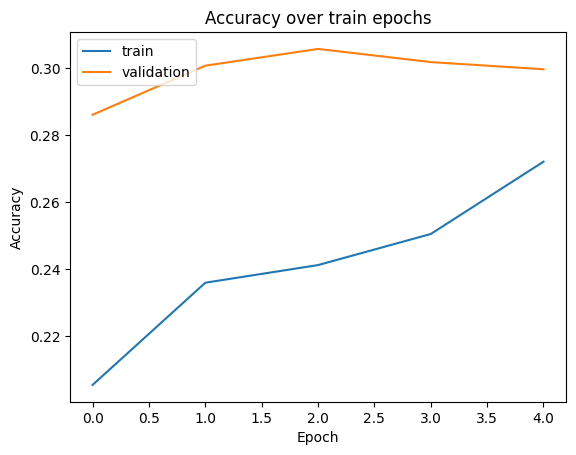

In [108]:
# Convolucional usando convoluciones ya entrenadas de ResNet
pretrained_model = ResNet50(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16 = Sequential([
    pretrained_model,
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

16719872/16705208 [==============================] - 2s 0us/step
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
flatten_26 (Flatten)         (None, 20480)             0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               5243136   
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
______________________________________________________

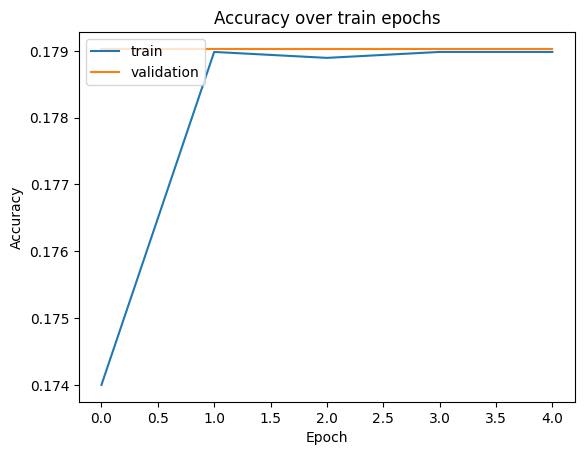

In [109]:
# Convolucional usando convoluciones ya entrenadas de EfficientNetB0
pretrained_model = EfficientNetB0(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16 = Sequential([
    pretrained_model,
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 49152)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 500)               24576500  
_________________________________________________________________
dropout_34 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 6)                 3006      
Total params: 24,579,506
Trainable params: 24,579,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
351/351 [==============================] - 67s 190ms/step - loss: 2.3870 - accuracy: 0.1647 - val_loss: 1.8038 - val_accuracy: 0.1690
Epoch 2/5
351/351 [==============================] - 67s 190ms/step - loss: 1.9755 - accuracy: 

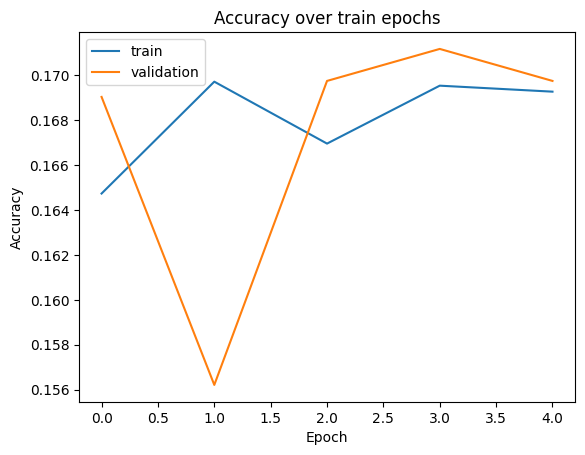

In [110]:
# MLP simple
model_mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_mlp.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_mlp.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 125, 125, 10)      490       
_________________________________________________________________
dropout_35 (Dropout)         (None, 125, 125, 10)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 122, 122, 10)      1610      
_________________________________________________________________
dropout_36 (Dropout)         (None, 122, 122, 10)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 30, 30, 10)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 9000)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)             

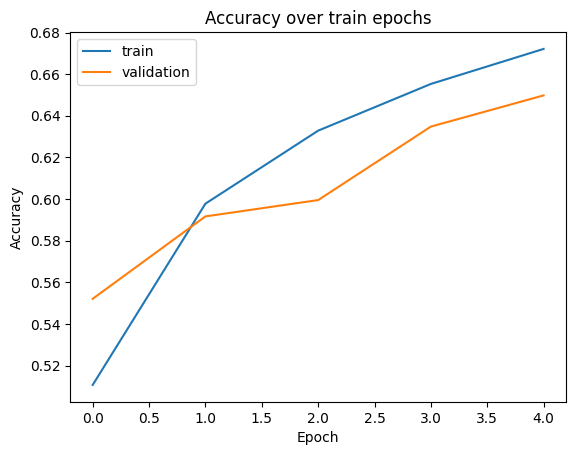

In [111]:
# Convolucional
model_convolucional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_29 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               819300    
_________________________________________________________________
dense_74 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_75 (Dense)             (None, 6)                 606       
Total params: 15,544,694
Trainable params: 830,006
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
351/351 [==============================] - 246s 700ms/step - loss: 0.6710 - accuracy: 0.743

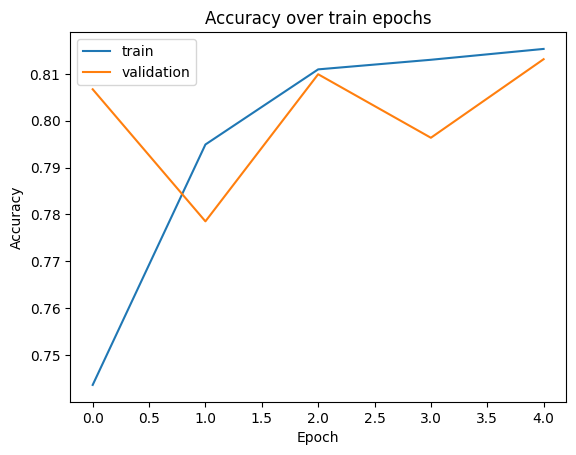

In [112]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 25088)           

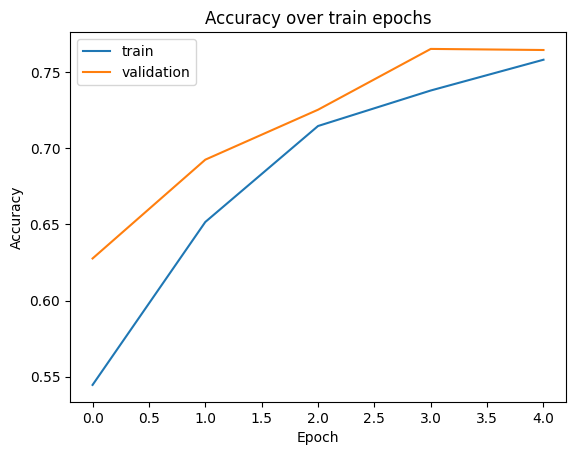

In [113]:
# Convolucional con mas capas/neuronas
model_convolucional = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(TIPO_IMAGENES), activation='softmax')
])

model_convolucional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 25088)           

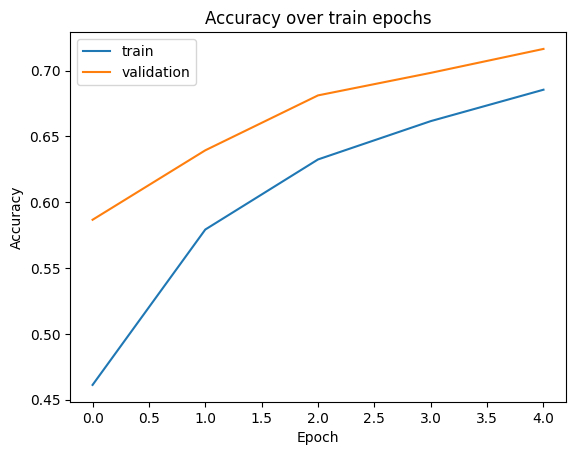

In [114]:
# Convolucional con mas capas/neuronas
model_convolucional = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(TIPO_IMAGENES), activation='softmax')
])

model_convolucional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_32 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 6)               

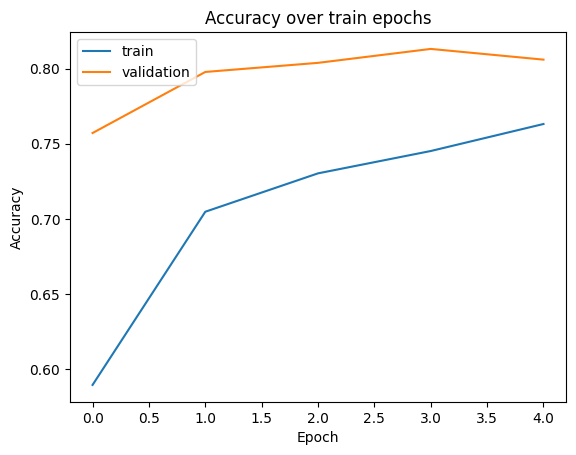

In [115]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_convolucional_vgg16 = Sequential([
    pretrained_model,
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(len(TIPO_IMAGENES), activation='softmax'),
])

model_convolucional_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)
model_convolucional_vgg16.summary()

model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

history = model_convolucional_vgg16.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [117]:
# nos podemos quedar con los mejores pesos, o dejarlos como están después de la última epoch
model_convolucional_vgg16.set_weights(model_weights_at_epochs[3])

<h1>Nuestras Predicciones</h1>

In [118]:
from IPython.display import Image, display

def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model_convolucional_vgg16.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", TIPO_IMAGENES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

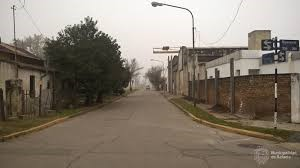

Prediction: street
Prediction detail: [[3.6374277e-19 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0000000e+00]]


In [119]:
show_and_predict(r"C:\Users\54934\Downloads\rafaela.jpg")